# An Introduction to Prompting for LLMs

https://medium.com/data-science/an-introduction-to-prompting-for-llms-61d36aec2048

Download data from https://drive.google.com/file/d/1ImYUSLk9JbgHXOemfvyiDiirluZHPeQw/view

In [ ]:
!pip install -q hf_xet transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 114.5 MB/s eta 0:00:00


In [1]:
import zipfile

# Path to your zip file
zip_path = 'data_clean.zip'

# Directory to extract to
extract_to = './data'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f'Extracted to {extract_to}')

Extracted to ./data


In [2]:
import json
import random

random.seed(42)

def read_jsonl_file(file_path):
    """
    Parses a JSONL (JSON Lines) file and returns a list of dictionaries.

    Args:
        file_path (str): The path to the JSONL file to be read.

    Returns:
        list of dict: A list where each element is a dictionary representing
            a JSON object from the file.
    """
    with open(file_path, 'r', encoding="utf-8") as file:
        return [json.loads(line) for line in file]

def write_jsonl_file(dict_list, file_path):
    """
    Write a list of dictionaries to a JSON Lines file.

    Args:
    - dict_list (list): A list of dictionaries to write to the file.
    - file_path (str): The path to the file where the data will be written.
    """
    with open(file_path, 'w') as file:
        for dictionary in dict_list:
            # Convert the dictionary to a JSON string and write it to the file.
            json_line = json.dumps(dictionary)
            file.write(json_line + '\n')

# read the contents of the train and test set
train_set = read_jsonl_file("data/data_clean/questions/US/4_options/phrases_no_exclude_train.jsonl")
test_set = read_jsonl_file("data/data_clean/questions/US/4_options/phrases_no_exclude_test.jsonl")

# subsample test set samples and few-shot samples
test_set_subsampled = random.sample(test_set, 300)
few_shot_examples = random.sample(test_set, 3)

# dump the sampled questions and few-shot samples as jsonl files
write_jsonl_file(test_set_subsampled, "data/USMLE_test_samples_300.jsonl")
write_jsonl_file(few_shot_examples, "data/USMLE_few_shot_samples.jsonl")

questions = read_jsonl_file("data/USMLE_test_samples_300.jsonl")

## Prompting Llama 2 7B-Chat with a Zero-Shot Prompt

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from google.colab import userdata

HUGGING_FACE_TOKEN = userdata.get('HUGGING_FACE_ACCESS_TOKEN')

model_id: str = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model_id, token=HUGGING_FACE_TOKEN)

model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16, token=HUGGING_FACE_TOKEN).cuda()

model.eval()

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_e

In [3]:
def create_query(item: dict)->str:
    return f"{item.get('question')}\noptions:\n"\
        f"A. {item.get('options').get('A')}\n"\
        f"B. {item.get('options').get('B')}\n"\
        f"C. {item.get('options').get('C')}\n"\
        f"D. {item.get('options').get('D')}"

def build_zero_shot_prompting(system_prompt: str, content: dict)->list[dict]:
    return [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": create_query(content) }
    ]

PROMPT = """You will be provided with a medical or clinical question, along with multiple possible answer choices. Pick the right answer from the choices.
Your response should be in the format "The answer is <correct_choice>". Do not add any other unnecessary content in your response"""

In [ ]:
%%time

from typing import Callable

class AnswerGenerator:
    def __init__(self, prompt: str, prompt_builder: Callable, questions: list, *prompt_args)->None:
        self.__prompt = prompt
        self.__prompt_builder = prompt_builder
        self.__questions = questions
        self.__prompt_args = prompt_args

    def __get_llama_answers(self, item: dict)->str:
        prompt_messages =  self.__prompt_builder(self.__prompt, item, *self.__prompt_args)
        input_ids = tokenizer.apply_chat_template(prompt_messages, tokenize=True, return_tensors="pt").to("cuda")
        with torch.no_grad():
            outputs = model.generate(input_ids=input_ids, max_new_tokens=10, do_sample=True)
        cpu_outputs = outputs.detach().cpu()
        gen_text = tokenizer.batch_decode(cpu_outputs[:, input_ids.shape[1]:], skip_special_tokens=True)[0]
        return gen_text.strip()

    def __generate_answer(self):
        for question in self.__questions:
            yield self.__get_llama_answers(question)

    def __call__(self)->list[str]:
        return list(self.__generate_answer())

answer_generator = AnswerGenerator(prompt=PROMPT, prompt_builder=build_zero_shot_prompting, questions=questions)

zero_shot_llama_answers: list[str] = answer_generator()

CPU times: user 3min 22s, sys: 779 ms, total: 3min 23s
Wall time: 3min 22s


In [ ]:
zero_shot_llama_answers[:5]

['The answer is B: Dengue fe',
 'The answer is A: Aldosterone excess',
 'The answer is A: Clear cell aden',
 'The answer is B: Ability to cle',
 'The answer is C: It only occurs in']

In [4]:
import numpy as np
import re

pattern = re.compile(r"([A-Z])\.\s*(.*)")

def parse_answer(response)->str:
    """
    Extracts the answer option from the predicted string.

    Args:
    - response (str): The string to search for the pattern.

    Returns:
    - str: The matched answer option if found or an empty string otherwise.
    """
    match = re.search(pattern, response)
    if match:
        letter = match.group(1)
    else:
        letter = ""

    return letter.strip()

def accuracy(target: list[str], predictions: list[str])->float:
    return (np.array(target)==np.array(predictions)).mean().item()

ground_truth: list[str] = [item["answer_idx"] for item in questions]

In [ ]:
zero_shot_llama_predictions: list[str] = [parse_answer(answer) for answer in zero_shot_llama_answers]

acc: float = accuracy(zero_shot_llama_predictions, ground_truth)

print("Accuracy in Zero-shot: {0:.3f} ({0:.2%})".format(acc))

Accuracy in Zero-shot: 0.090 (9.00%)


## Prompting Llama 2 7B-Chat with a Few-Shot Prompt

In [6]:
def build_few_shot_prompt(system_prompt: str, content: dict, few_shot_examples: list)->list[dict]:
    messages = [{"role": "system", "content": system_prompt}]
    for item in few_shot_examples:
        messages.append({"role": "user", "content": create_query(item)})
        messages.append({"role": "assistant", "content": f"The answer is {item['answer_idx']}"})
    messages.append({"role": "user", "content": create_query(content)})
    return messages

few_shot_prompts = read_jsonl_file("data/USMLE_few_shot_samples.jsonl")

few_shot_prompt_messages: list[dict] = build_few_shot_prompt(PROMPT, questions[0], few_shot_examples)

Raw prompt:

In [ ]:
few_shot_prompt_messages

[{'role': 'system',
  'content': 'You will be provided with a medical or clinical question, along with multiple possible answer choices. Pick the right answer from the choices.\nYour response should be in the format "The answer is <correct_choice>". Do not add any other unnecessary content in your response'},
 {'role': 'user',
  'content': 'A 4-year-old girl is brought to the emergency department with a persistent cough, fever, and vomiting. The past year the child has been admitted to the hospital 3 times with pneumonia. For the past 1 week, the child has been experiencing thick purulent cough and says that her chest feels ‘heavy’. Her stools have been loose and foul-smelling over the past week. Her parents are also concerned that she has not gained much weight due to her frequent hospital visits. She was born at 39 weeks gestation via spontaneous vaginal delivery and is up to date on all vaccines and is meeting all developmental milestones. On physical exam, the temperature is 39.1°C

Rendered prompt:

In [ ]:
print(tokenizer.apply_chat_template(few_shot_prompt_messages, tokenize=False))

<s>[INST] <<SYS>>
You will be provided with a medical or clinical question, along with multiple possible answer choices. Pick the right answer from the choices.
Your response should be in the format "The answer is <correct_choice>". Do not add any other unnecessary content in your response
<</SYS>>

A 4-year-old girl is brought to the emergency department with a persistent cough, fever, and vomiting. The past year the child has been admitted to the hospital 3 times with pneumonia. For the past 1 week, the child has been experiencing thick purulent cough and says that her chest feels ‘heavy’. Her stools have been loose and foul-smelling over the past week. Her parents are also concerned that she has not gained much weight due to her frequent hospital visits. She was born at 39 weeks gestation via spontaneous vaginal delivery and is up to date on all vaccines and is meeting all developmental milestones. On physical exam, the temperature is 39.1°C (102.4°F). She appears lethargic and unco

In [ ]:
%%time

answer_generator_few_shots = AnswerGenerator(PROMPT, build_few_shot_prompt, questions, few_shot_examples)

few_shots_llama_answers: list[str] = answer_generator_few_shots()

CPU times: user 1min 57s, sys: 0 ns, total: 1min 57s
Wall time: 1min 57s


In [ ]:
few_shots_llama_answers[:5]

['The answer is B',
 'The answer is A: Aldosterone excess.',
 'The answer is A. Clear cell adenoc',
 'The answer is B: Ability to cleave',
 'The answer is B: It is a diagnosis']

In [ ]:
few_shots_llama_predictions: list[str] = [parse_answer(answer) for answer in few_shots_llama_answers]

acc: float = accuracy(few_shots_llama_predictions, ground_truth)

print("Accuracy in Few-shots: {0:.3f} ({0:.2%})".format(acc))

Accuracy in Few-shots: 0.137 (13.67%)


## What happens if we don’t adhere to the chat template?

In [ ]:
def build_few_shot_prompt_no_chat_template(system_prompt: str, content: dict, few_shot_examples: list)->str:
    few_shot_prompt: str = f"Task: {system_prompt}\n\n"
    for item in few_shot_examples:
        few_shot_prompt+=create_query(item)+"\n"
        few_shot_prompt+=f"The answer is {item['answer_idx']}.\n\n"
    few_shot_prompt+=create_query(content)+"\n"
    return few_shot_prompt

few_shot_prompts = read_jsonl_file("data/USMLE_few_shot_samples.jsonl")

few_shot_prompt_wo_chat_template: str = build_few_shot_prompt_no_chat_template(PROMPT, questions[0], few_shot_prompts)

print(few_shot_prompt_wo_chat_template)

Task: You will be provided with a medical or clinical question, along with multiple possible answer choices. Pick the right answer from the choices.
Your response should be in the format "The answer is <correct_choice>". Do not add any other unnecessary content in your response

A 4-year-old girl is brought to the emergency department with a persistent cough, fever, and vomiting. The past year the child has been admitted to the hospital 3 times with pneumonia. For the past 1 week, the child has been experiencing thick purulent cough and says that her chest feels ‘heavy’. Her stools have been loose and foul-smelling over the past week. Her parents are also concerned that she has not gained much weight due to her frequent hospital visits. She was born at 39 weeks gestation via spontaneous vaginal delivery and is up to date on all vaccines and is meeting all developmental milestones. On physical exam, the temperature is 39.1°C (102.4°F). She appears lethargic and uncomfortable. Crackles a

In [ ]:
%%time

answer_generator_few_shot_no_chat_template = AnswerGenerator(PROMPT, build_few_shot_prompt_no_chat_template, questions, few_shot_prompts)

few_shot_no_chat_template_llama_answers: list[str] = answer_generator_few_shot_no_chat_template()

TemplateError: Conversation roles must alternate user/assistant/user/assistant/...

## Prompting Llama 2 7B-Chat with CoT Prompting

In [11]:
QUESTION_1 = {"question": """Question: A 22-year-old male marathon runner presents to the office with the complaint of right-sided rib pain when he runs long distances. Physical examination reveals normal heart and lung findings and an exhalation dysfunction at ribs 4-5 on the right. Which of the following muscles or muscle groups will be most useful in correcting this dysfunction utilizing a direct method?
(A) anterior scalene (B) latissimus dorsi (C) pectoralis minor (D) quadratus lumborum""",
             "explanation": """Explanation: We refer to Wikipedia articles on medicine for help. Among the options, only pectoralis minor muscle origins from the outer surfaces of the 3rd to 5th ribs.
Answer: (C)"""}

QUESTION_2 = {"question": """Question: A 36-year-old male presents to the office with a 3-week history of low back pain. He denies any recent trauma but says that he climbs in and out of his truck numerous times a day for his job. Examination of the patient in the prone position reveals a deep sacral sulcus on the left, a posterior inferior lateral angle on the right, and a lumbosacral junction that springs freely on compression. The most likely diagnosis is
(A) left-on-left sacral torsion (B) left-on-right sacral torsion (C) right unilateral sacral flexion (D) right-on-right sacral torsion""",
             "explanation": """Explanation: We refer to Wikipedia articles on medicine for help. The deep sulcus on the left, a posterior ILA on the right, with a negative spring test suggests a right-on-right sacral torsion. All other options have a deep sulcus on the right.
Answer: (D)"""}

QUESTION_3 = {"question": """Question: A 44-year-old man comes to the office because of a 3-day history of sore throat, nonproductive cough, runny nose, and frontal headache. He says the headache is worse in the morning and ibuprofen does provide some relief. He has not had shortness of breath. Medical history is unremarkable. He takes no medications other than the ibuprofen for pain. Vital signs are temperature 37.4°C (99.4°F), pulse 88/min, respirations 18/min, and blood pressure 120/84 mm Hg. Examination of the nares shows erythematous mucous membranes. Examination of the throat shows erythema and follicular lymphoid hyperplasia on the posterior oropharynx. There is no palpable cervical adenopathy. Lungs are clear to auscultation. Which of the following is the most likely cause of this patient’s symptoms?
(A) Allergic rhinitis (B) Epstein-Barr virus (C) Mycoplasma pneumonia (D) Rhinovirus""",
             "explanation": """Explanation: We refer to Wikipedia articles on medicine for help. The symptoms, especially the headache, suggest that the most likely cause is Rhinovirus. Epstein-Barr virus will cause swollen lymph nodes but there is no palpable cervical adenopathy. Lungs are clear to auscultation suggests it’s not Mycoplasma pneumonia.
Answer: (D)"""}


QUESTION_4 = {"question": """Question: A previously healthy 32-year-old woman comes to the physician 8 months after her husband was killed in a car crash. Since that time, she has had a decreased appetite and difficulty falling asleep. She states that she is often sad and cries frequently. She has been rechecking the door lock five times before leaving her house and has to count exactly five pieces of toilet paper before she uses it. She says that she has always been a perfectionist but these urges and rituals are new. Pharmacotherapy should be targeted to which of the following neurotransmitters?
(A) Dopamine (B) Glutamate (C) Norepinephrine (D) Serotonin""",
             "explanation": """Explanation: We refer to Wikipedia articles on medicine for help. The patient feels sad and among the options, only Dopamine and Serotonin can help increase positive emotions. Serotonin also affects digestion and metabolism, which can help the patient’s decreased appetite and sleep difficulty.
Answer: (D)"""}


QUESTION_5 = {"question": """Question: A 42-year-old man comes to the office for preoperative evaluation prior to undergoing adrenalectomy scheduled in 2 weeks. One month ago, he received care in the emergency department for pain over his right flank following a motor vehicle collision. At that time, blood pressure was 160/100 mm Hg and CT scan of the abdomen showed an incidental 10-cm left adrenal mass. Results of laboratory studies, including complete blood count, serum electrolyte concentrations, and liver function tests, were within the reference ranges. The patient otherwise had been healthy and had never been told that he had elevated blood pressure. He takes no medications. A follow-up visit in the office 2 weeks ago disclosed elevated urinary normetanephrine and metanephrine and plasma aldosterone concentrations. The patient was referred to a surgeon, who recommended the adrenalectomy. Today, vital signs are temperature 36.6°C (97.9°F), pulse 100/min, respirations 14/min, and blood pressure 170/95 mm Hg. Physical examination discloses no significant findings. Initial preoperative preparation should include treatment with which of the following?
(A) Labetalol (B) A loading dose of potassium chloride (C) Nifedipine (D) Phenoxybenzamine""",
             "explanation": """Explanation: We refer to Wikipedia articles on medicine for help. The symptoms and the adrenal mass suggested pheochromocytoma, and the blood pressure indicates hypertension. Phenoxybenzamine is used to treat hypertension caused by pheochromocytoma.
Answer: (D)"""}

COT_EXAMPLES = [QUESTION_1, QUESTION_2, QUESTION_3, QUESTION_4, QUESTION_5]

def create_query_cot(item):
    """
    Creates the input for the model using the question and the multiple choice options in the CoT format.

    Args:
        item (dict): A dictionary containing the question and options.
            Expected keys are "question" and "options", where "options" is another
            dictionary with keys "A", "B", "C", and "D".

    Returns:
        str: A formatted query combining the question and options, ready for use.
    """
    return "Question: " + item["question"] + "\n" + \
            "(A) " + item["options"]["A"] + " " +  \
            "(B) " + item["options"]["B"] + " " +  \
            "(C) " + item["options"]["C"] + " " +  \
            "(D) " + item["options"]["D"]

def build_cot_prompt(system_prompt: str, content: dict, cot_examples: list):
    messages = [{"role": "system", "content": system_prompt}]
    for item in cot_examples:
        messages.append({"role": "user", "content": item["question"]})
        messages.append({"role": "assistant", "content": f"Explanation {item['explanation']}"})
    messages.append({"role": "user", "content": create_query_cot(content)})
    return messages

COT_INSTRUCTION = """Instructions: The following are multiple-choice questions about medical knowledge. Solve them in a step-by-step fashion.
Your response should be in the format "The answer is <correct_choice>". Do not add any other unnecessary content in your response."""

cot_prompt_chat_template: str = build_cot_prompt(COT_INSTRUCTION, questions[0], COT_EXAMPLES)

cot_prompt_chat_template

[{'role': 'system',
  'content': 'Instructions: The following are multiple-choice questions about medical knowledge. Solve them in a step-by-step fashion.\nYour response should be in the format "The answer is <correct_choice>". Do not add any other unnecessary content in your response.'},
 {'role': 'user',
  'content': 'Question: A 22-year-old male marathon runner presents to the office with the complaint of right-sided rib pain when he runs long distances. Physical examination reveals normal heart and lung findings and an exhalation dysfunction at ribs 4-5 on the right. Which of the following muscles or muscle groups will be most useful in correcting this dysfunction utilizing a direct method?\n(A) anterior scalene (B) latissimus dorsi (C) pectoralis minor (D) quadratus lumborum'},
 {'role': 'assistant',
  'content': 'Explanation Explanation: We refer to Wikipedia articles on medicine for help. Among the options, only pectoralis minor muscle origins from the outer surfaces of the 3rd 

In [ ]:
%%time

answer_generator_cot = AnswerGenerator(COT_INSTRUCTION, build_cot_prompt, questions, COT_EXAMPLES)

cot_llama_answers: list[str] = answer_generator_cot()

CPU times: user 5min 38s, sys: 24.8 s, total: 6min 3s
Wall time: 6min 2s


In [ ]:
cot_llama_answers[:5]

['Explanation Explanation: We refer to',
 'Explanation Explanation: We refer to',
 'Explanation Explanation: We refer to',
 'Explanation Explanation: We refer to',
 'Explanation Explanation: We refer to']

After, 4 runs it finally did not work as expected! :(

## Zero-Shot with OpenAI

In [5]:
from openai import OpenAI
from google.colab import userdata
from typing import Callable
from concurrent.futures import ThreadPoolExecutor

OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

client = OpenAI(api_key=OPENAI_API_KEY)


class AnswerGeneratorOpenAI:
    def __init__(
            self,
            model_name: str,
            prompt: str,
            prompt_builder: Callable,
            questions: list,
            temperature: float,
            *prompt_args)->None:
        self.__model_name = model_name
        self.__prompt = prompt
        self.__prompt_builder = prompt_builder
        self.__questions = questions
        self.__temperature = temperature
        self.__prompt_args = prompt_args

    def __get_openai_answers(self, item: dict)->str:
        prompt_messages =  self.__prompt_builder(self.__prompt, item, *self.__prompt_args)
        response = client.chat.completions.create(
            model=self.__model_name,
            messages=prompt_messages,
            temperature=self.__temperature
        )
        return response.choices[0].message.content.strip()

    def __generate_answer(self)->iter:
        with ThreadPoolExecutor() as executor:
            return executor.map(self.__get_openai_answers, self.__questions)

    def __call__(self)->list[str]:
        return list(self.__generate_answer())

In [30]:
%%time

answer_generator_openai = AnswerGeneratorOpenAI(
    model_name="gpt-4o",
    prompt=PROMPT,
    prompt_builder=build_zero_shot_prompting,
    questions=questions,
    temperature=0.0
)

zero_shot_openai_answers: list[str] = answer_generator_openai()

zero_shot_openai_answers[:5]

CPU times: user 1.86 s, sys: 105 ms, total: 1.97 s
Wall time: 34.6 s


['The answer is A. Chikungunya',
 'The answer is A. Aldosterone excess',
 'The answer is A. Clear cell adenocarcinoma',
 'The answer is D. Adaptation in binding proteins',
 'The answer is B. It is a diagnosis of exclusion']

**Sequential execution takes around 4 minutes!!!**

In [31]:
zero_shot_openai_predictions: list[str] = [parse_answer(answer) for answer in zero_shot_openai_answers]

acc_zero_shot_openai: float = accuracy(zero_shot_openai_predictions, ground_truth)

print("Accuracy in Zero-shot OpenAI: {0:.3f} ({0:.2%})".format(acc_zero_shot_openai))

Accuracy in Zero-shot OpenAI: 0.900 (90.00%)


## Few-Shot with OpenAI

In [32]:
%%time

answer_generator_few_shots_openai = AnswerGeneratorOpenAI(
    "gpt-4o",
    PROMPT,
    build_few_shot_prompt,
    questions,
    0.0,
    few_shot_examples
)

few_shot_openai_answers: list[str] = answer_generator_few_shots_openai()

few_shot_openai_predictions: list[str] = [parse_answer(answer) for answer in few_shot_openai_answers]

acc_few_shot_openai: float = accuracy(few_shot_openai_predictions, ground_truth)

print("Accuracy with Few-shot OpenAI: {0:.3f} ({0:.2%})".format(acc_few_shot_openai))

Accuracy with Few-shot OpenAI: 0.513 (51.33%)
CPU times: user 2.19 s, sys: 108 ms, total: 2.3 s
Wall time: 35.2 s


## CoT with OpenAI

In [33]:
def parse_answer_cot(text):
    """
    Extracts the letter inside parentheses following 'The answer is' from the sentence.

    Args:
        sentence (str): A sentence containing the answer.

    Returns:
        str: The extracted letter, or None if not found.
    """
    match = re.search(r'The answer is \((\w)\)', text)
    return match.group(1) if match else None

In [34]:
%%time

answer_generator_cot_openai = AnswerGeneratorOpenAI(
    "gpt-4o",
    COT_INSTRUCTION,
    build_cot_prompt,
    questions,
    0.0,
    COT_EXAMPLES
)

cot_openai_answers: list[str] = answer_generator_cot_openai()

CPU times: user 2.6 s, sys: 123 ms, total: 2.73 s
Wall time: 31.9 s


In [35]:
cot_openai_predictions: list[str] = [parse_answer_cot(answer) for answer in cot_openai_answers]

acc_cot_openai: float = accuracy(cot_openai_predictions, ground_truth)

print("Accuracy with CoT OpenAI: {0:.3f} ({0:.2%})".format(acc_cot_openai))

Accuracy with CoT OpenAI: 0.907 (90.67%)


In [36]:
cot_openai_answers[:5]

['The answer is (A) Chikungunya',
 'The answer is (A) Aldosterone excess.',
 'The answer is (A) Clear cell adenocarcinoma.',
 'The answer is (D) Adaptation in binding proteins.',
 'The answer is (B) It is a diagnosis of exclusion']

### Results OpenAI

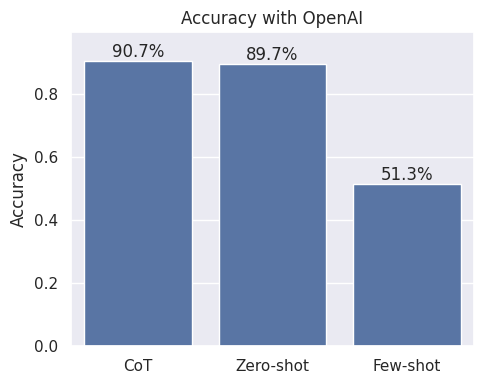

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))

sns.set()

results_openai: dict[str, float] = {
    "Zero-shot": acc_zero_shot_openai,
    "Few-shot": acc_few_shot_openai,
    "CoT": acc_cot_openai
}
sorted_results: dict = dict(sorted(results_openai.items(), key=lambda x: -x[1]))

plt.title("Accuracy with OpenAI")
ax = sns.barplot(x=list(sorted_results.keys()), y=list(sorted_results.values()))

for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1%}",
        ha='center',
        va='bottom'
    )

plt.ylabel("Accuracy")
plt.ylim(0, 1.1 * max(sorted_results.values()))
plt.tight_layout()
plt.show()